# Chapter 2: Agile Tools

In this chapter we will briefly introduce our software stack, enabling you to see the tools in action and become proficient in their use.

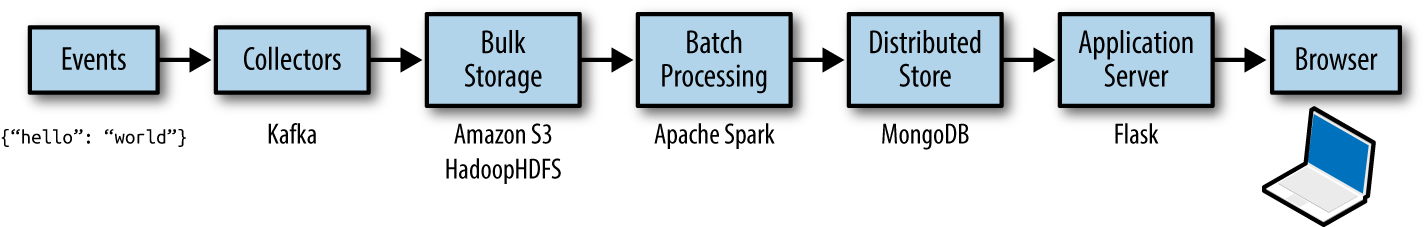

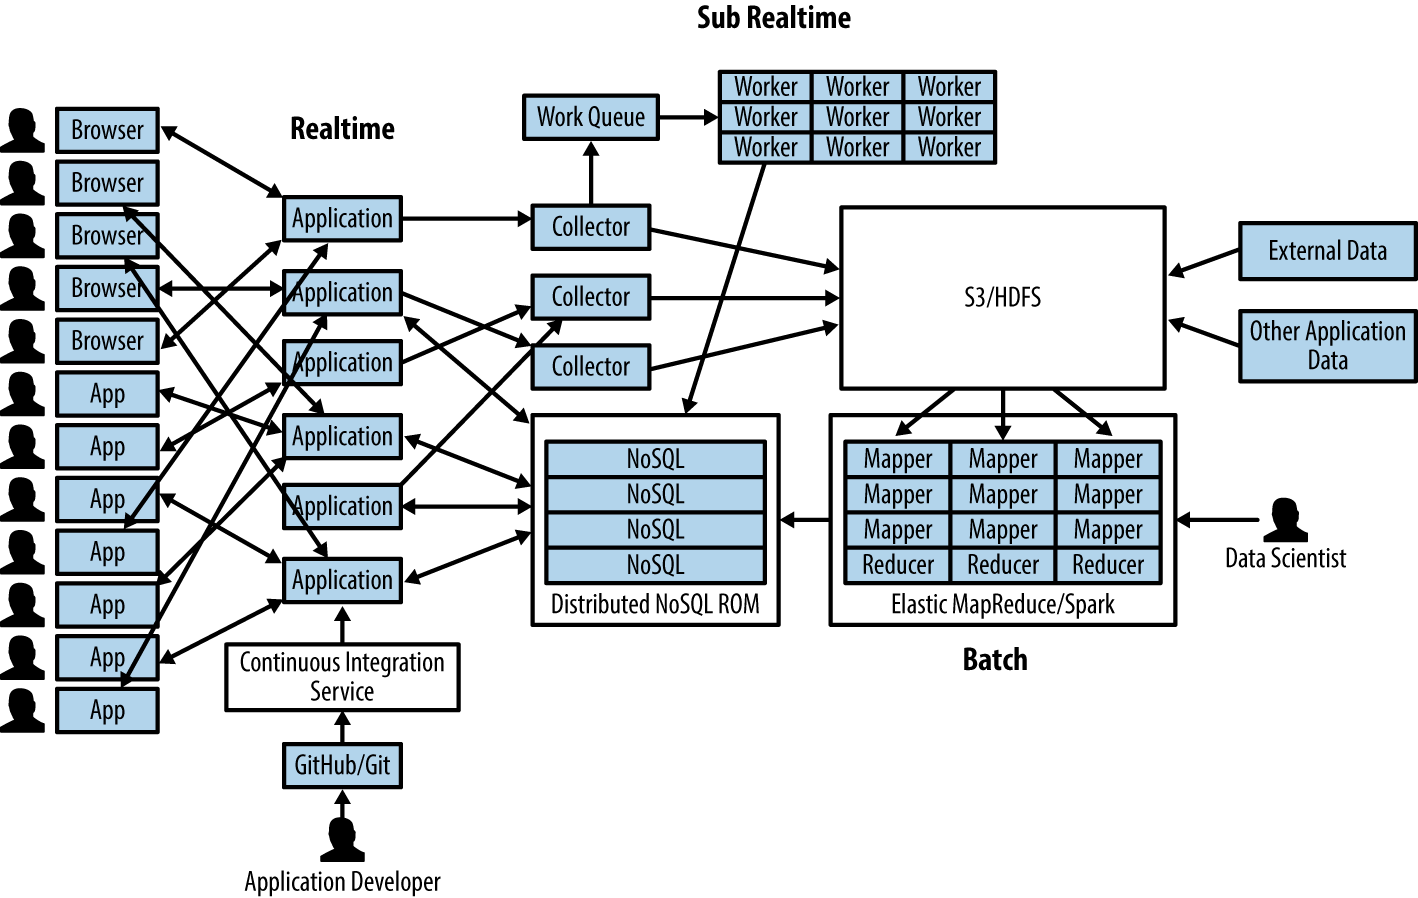

## Working with JSON

We'll be working with JSON throughout the book, both to store and process data in the 'back end' and to send data from a web application to the 'front end' web browser. In agile data science, we will often collect, process and store events in JSON format.

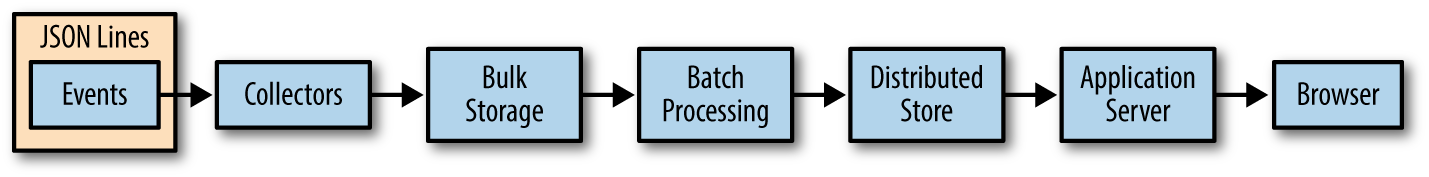



In [8]:
#
# How to read and write JSON and JSON Lines files using Python
#
import sys, os, re
import json
import codecs

ary_of_objects = [
  {'name': 'Russell Jurney', 'title': 'CEO'},
  {'name': 'Muhammad Imran', 'title': 'VP of Marketing'},
  {'name': 'Fe Mata', 'title': 'Chief Marketing Officer'},
]

path = "/tmp/test.jsonl"

#
# Write our objects to jsonl
#
f = codecs.open(path, 'w', 'utf-8')
for row_object in ary_of_objects:
  # ensure_ascii=False is essential or errors/corruption will occur
  json_record = json.dumps(row_object, ensure_ascii=False)
  f.write(json_record + "\n")

f.close()

print("Wrote JSON Lines file /tmp/test.jsonl\n")

#
# Read this jsonl file back into objects
#
ary_of_objects = []
f = codecs.open(path, "r", "utf-8")
for line in f:
  record = json.loads(line.rstrip("\n|\r"))
  ary_of_objects.append(record)

print(ary_of_objects)

print("\nRead JSON Lines file /tmp/test.jsonl")

Wrote JSON Lines file /tmp/test.jsonl

[{'name': 'Russell Jurney', 'title': 'CEO'}, {'name': 'Muhammad Imran', 'title': 'VP of Marketing'}, {'name': 'Fe Mata', 'title': 'Chief Marketing Officer'}]

Read JSON Lines file /tmp/test.jsonl


### Verifying our Work

Now lets verify that our file, `/tmp/test.jsonl` has been written. Go to the shell prompt for your virutal machine and type the command:

```
ls /tmp/test.jsonl
cat /tmp/test.jsonl
```

You should see the JSON that we wrote reproduced in your console.

## Data Processing with Spark

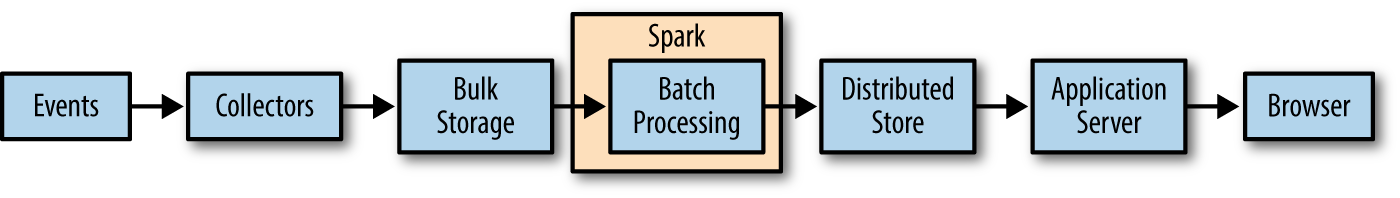

Once we have our data files on disk, we will use Spark to process them. Spark is a general purpose computing framework that scales well to handle large datasets by being distributed across multiple PC machines. In fact, Spark is the leading general-purpose distributed data processing platform. 

Spark works by breaking up data processing across networks of commodity PC machines, each acting on data on its own local disk and RAM. Spark’s job is to coordinate these machines into a single computing platform. The fact that Spark is a distributed platform is essential to it scaling to data of any size, and Spark is great at this. It works well in “local mode” on one machine, and it works well on clusters of thousands of machines. This meets our requirement that our tools scale to data of any size. Spark is also excellent glue, with connectors to many different systems including Kafka and databases like MongoDB.

Spark for Python is called PySpark. We'll be using PySpark, but note that Spark can also work with other languages like Java, Scala or R.

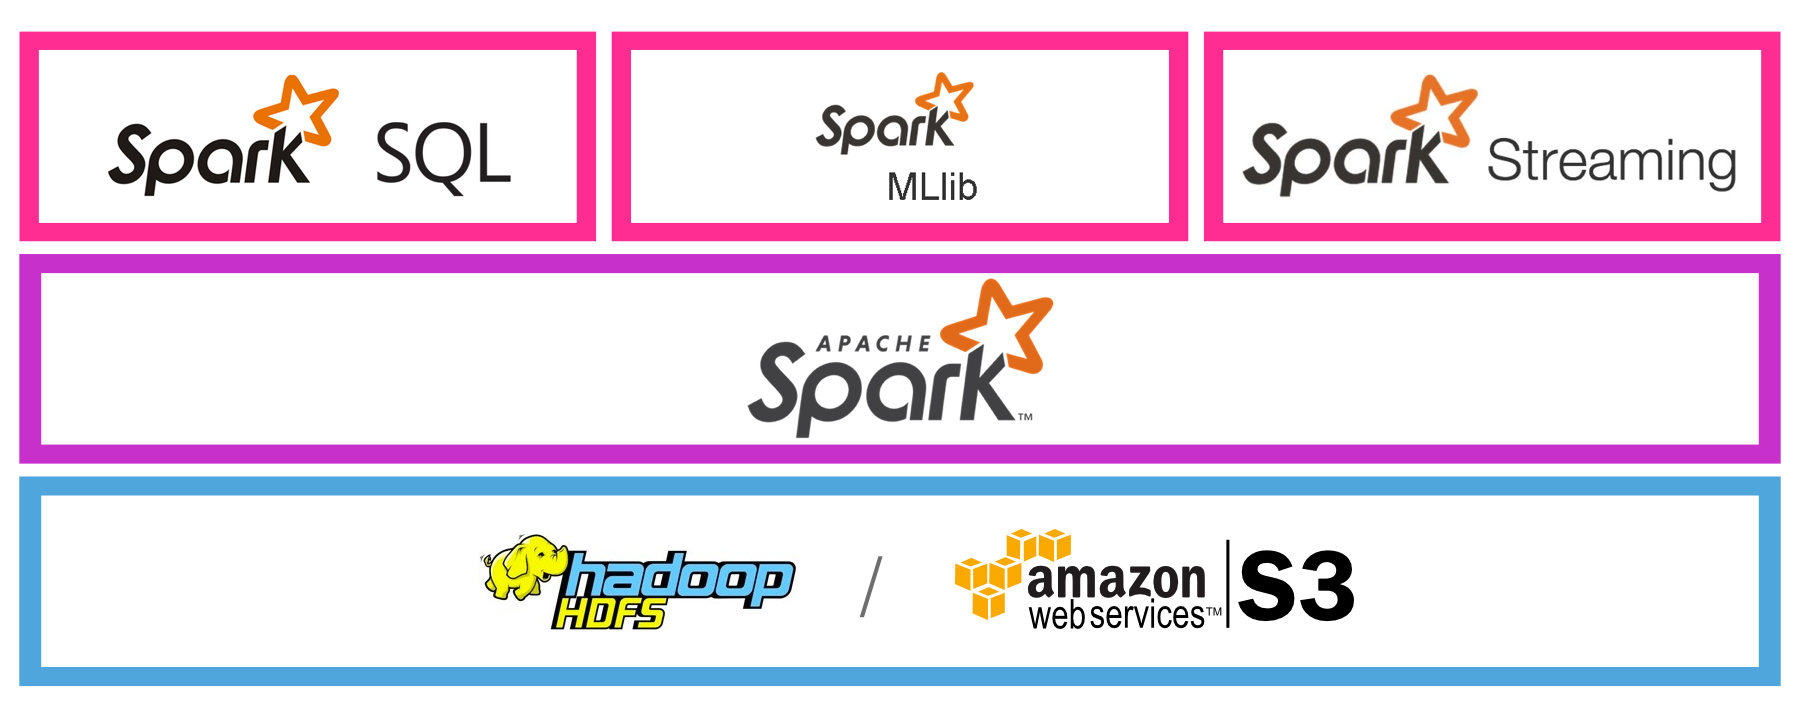

The image above describes the Spark ecosystem. Spark runs on top of HDFS or S3 and includes Spark SQL, Spark MLlib, and Spark Streaming. We'll be using Spark SQL and Spark MLlib later in this tutorial.

Spark __local mode__ lets us run Spark on small data locally, for development. We’ll be using Spark local mode throughout this course. The idea is that you can develop locally to learn, and then later on use a Spark cluster as your data grows —- although we should note that, with EC2 instances available with 2 TB of RAM, “local mode” in Spark can still process pretty big datasets! The reason to use a cluster, then, is more around reliability through redundancy and satisfying the cost/benefit curve, where multiple cheaper machines are less expensive than one monster.

## Initializing PySpark

We will be working with PySpark directly from Jupyter notebooks like this one. In order to initialize PySpark, you will need to run the following code. Give your application a name like `"Introducing PySpark"` and then run the code below. 

This will initialize the two objects you will need to use Spark: `SparkContext`, which is named `sc` and `SparkSessions` which is named `spark`. We will see how to use these two objects to perform work below.

In [11]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


You should see the words `PySpark initialized...` appear just above this text. This means you are ready to process data in Spark!

### Our First Spark Job

For our first Spark job, we're going to load some CSV (Comma Separated Value) data and count the number of records present. Note the use of the `map` command to run a function on each record (a line of text as input, and a list as output), and the use of the `collect` method to gather data from PySpark's memory (potentially on a large compute cluster) to local memory (on this machine you're using).

In [13]:
csv_lines = sc.textFile("../data/example.csv")
data = csv_lines.map(lambda line: line.split(","))
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

You can count the number of records in any RDD with the `count` method.

In [14]:
data.count()

6

## Dicts are Easier to Work With than Lists

It is easier to work with records that have named fields than to work with lists with numeric fields. Before we proceed, lets convert our data into dictionaries.

In [37]:
dict_data = data.map(
    lambda record: { 'name': record[0], 'company': record[1], 'title': record[2] }
)
dict_data.collect()

[{'name': 'Russell Jurney', 'company': 'Relato', 'title': 'CEO'},
 {'name': 'Florian Liebert', 'company': 'Mesosphere', 'title': 'CEO'},
 {'name': 'Don Brown', 'company': 'Rocana', 'title': 'CIO'},
 {'name': 'Steve Jobs', 'company': 'Apple', 'title': 'CEO'},
 {'name': 'Donald Trump', 'company': 'The Trump Organization', 'title': 'CEO'},
 {'name': 'Russell Jurney',
  'company': 'Data Syndrome',
  'title': 'Principal Consultant'}]

### Printing Data as JSON

Sometimes it is hard to read records without proper formatting. The `json` module can help with its `sort_keys` and `indent` options.

In [38]:
print(
    json.dumps(
        dict_data.collect(),
        indent=4,
        sort_keys=True
    )
)

[
    {
        "company": "Relato",
        "name": "Russell Jurney",
        "title": "CEO"
    },
    {
        "company": "Mesosphere",
        "name": "Florian Liebert",
        "title": "CEO"
    },
    {
        "company": "Rocana",
        "name": "Don Brown",
        "title": "CIO"
    },
    {
        "company": "Apple",
        "name": "Steve Jobs",
        "title": "CEO"
    },
    {
        "company": "The Trump Organization",
        "name": "Donald Trump",
        "title": "CEO"
    },
    {
        "company": "Data Syndrome",
        "name": "Russell Jurney",
        "title": "Principal Consultant"
    }
]


### Grouping Data

The `GROUP BY` is a fundamental operation in data processing. Lets see how this works in Spark. We will group the list of executives by job title.

In [35]:
grouped_by_title = dict_data.groupBy(
    lambda record: record['title']
)
grouped_by_title.collect()

[('CEO', <pyspark.resultiterable.ResultIterable at 0x7f3adb1948d0>),
 ('CIO', <pyspark.resultiterable.ResultIterable at 0x7f3adb1944a8>),
 ('Principal Consultant',
  <pyspark.resultiterable.ResultIterable at 0x7f3adb194cc0>)]

### Inspecting Grouped Data

Note that `RDD.groupBy` produces a tuple with two fields: the key we grouped by and a `pyspark.resultiterable.ResultIterable.` If you want to inspect each group, you can cast the `ResultIterable` to a `list`.

In [40]:
record_groups = grouped_by_title.map(
    lambda record: (
        record[0], 
        list(record[1])
    )
)

record_groups.collect()

[('CEO',
  [{'name': 'Russell Jurney', 'company': 'Relato', 'title': 'CEO'},
   {'name': 'Florian Liebert', 'company': 'Mesosphere', 'title': 'CEO'},
   {'name': 'Steve Jobs', 'company': 'Apple', 'title': 'CEO'},
   {'name': 'Donald Trump',
    'company': 'The Trump Organization',
    'title': 'CEO'}]),
 ('CIO', [{'name': 'Don Brown', 'company': 'Rocana', 'title': 'CIO'}]),
 ('Principal Consultant',
  [{'name': 'Russell Jurney',
    'company': 'Data Syndrome',
    'title': 'Principal Consultant'}])]

Once again, we can use JSON to more clearly format the data. This shows our grouped records: the group key, followed by a `list` of `dict` objects with the fields of our original `dict` records. There is nothing special about grouped data, it is simply grouped to be processed in its group context.

In [42]:
print(json.dumps(record_groups.collect(), indent=4, sort_keys=True))

[
    [
        "CEO",
        [
            {
                "company": "Relato",
                "name": "Russell Jurney",
                "title": "CEO"
            },
            {
                "company": "Mesosphere",
                "name": "Florian Liebert",
                "title": "CEO"
            },
            {
                "company": "Apple",
                "name": "Steve Jobs",
                "title": "CEO"
            },
            {
                "company": "The Trump Organization",
                "name": "Donald Trump",
                "title": "CEO"
            }
        ]
    ],
    [
        "CIO",
        [
            {
                "company": "Rocana",
                "name": "Don Brown",
                "title": "CIO"
            }
        ]
    ],
    [
        "Principal Consultant",
        [
            {
                "company": "Data Syndrome",
                "name": "Russell Jurney",
                "title": "Principal Consultant"
    

## Counting Grouped Data

In the `pyspark.RDD` API, the way we count groups is to use raw Python, the `len` command. We'll see later how the `pyspark.SQL` API uses higher level functions to do the same calculation.

In [43]:
title_counts = grouped_by_title.map(
    lambda record: (
        record[0], 
        len(record[1])
    )
)
title_counts.collect()

[('CEO', 4), ('CIO', 1), ('Principal Consultant', 1)]